# Look at performance of the model

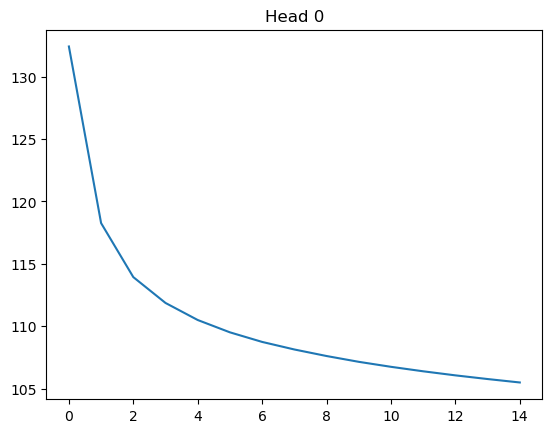

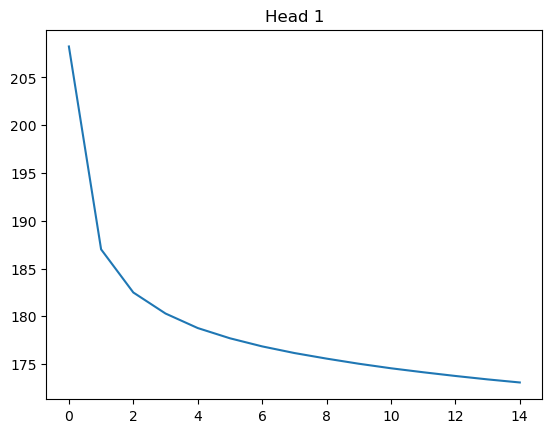

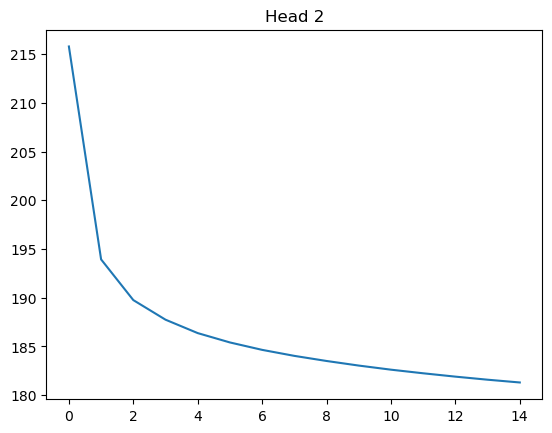

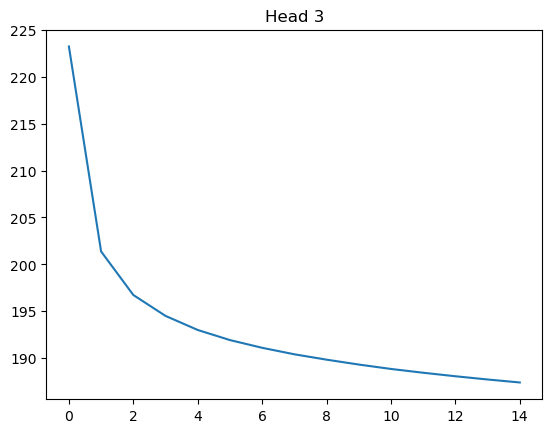

In [103]:
import torch
import matplotlib.pyplot as plt
import pickle
import io

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

with open('../results/train_res/w2_train_KLD_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()


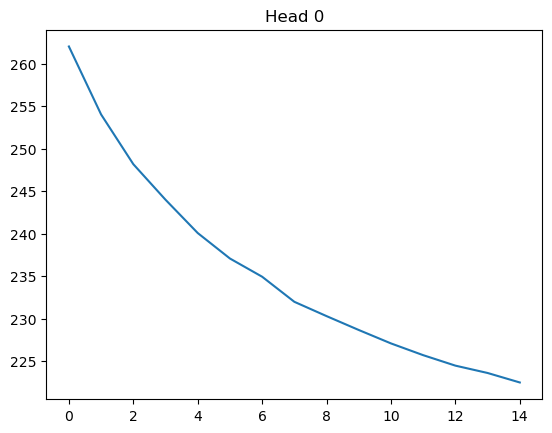

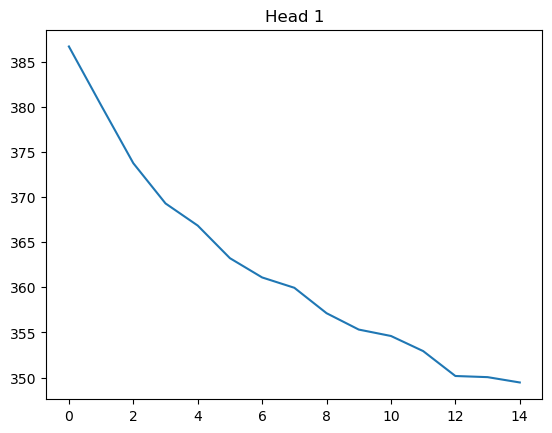

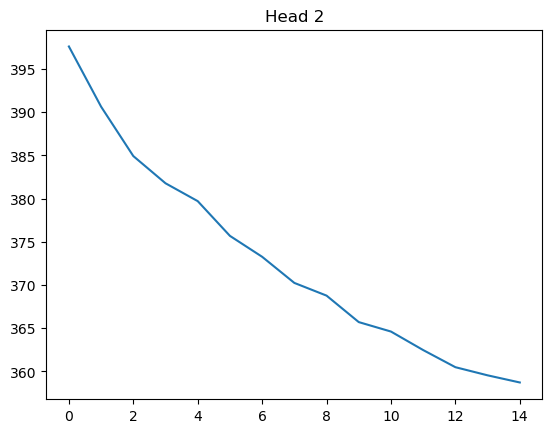

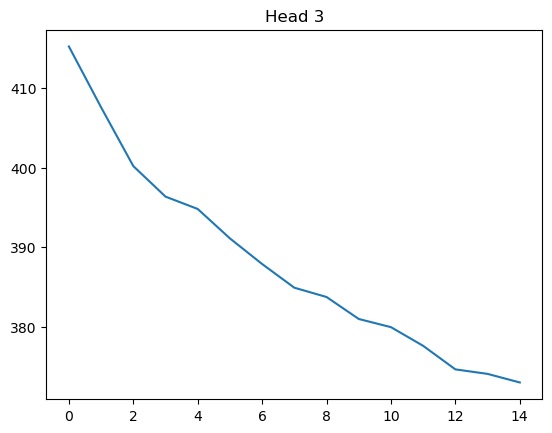

In [105]:
with open('../results/train_res/wbias_test_KLD_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()  

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()

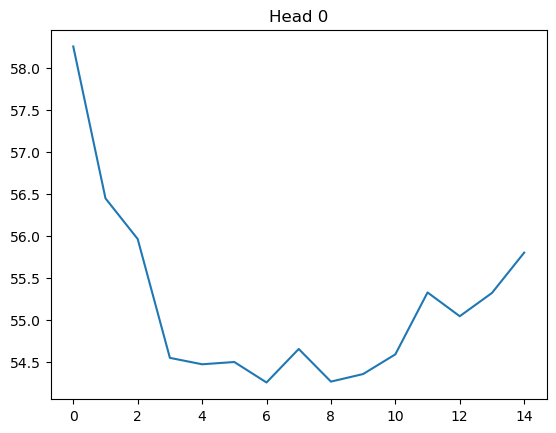

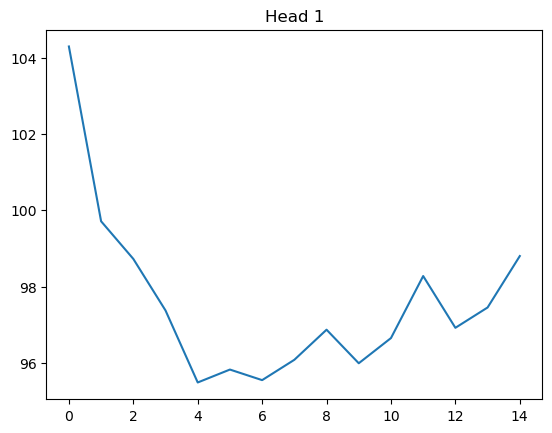

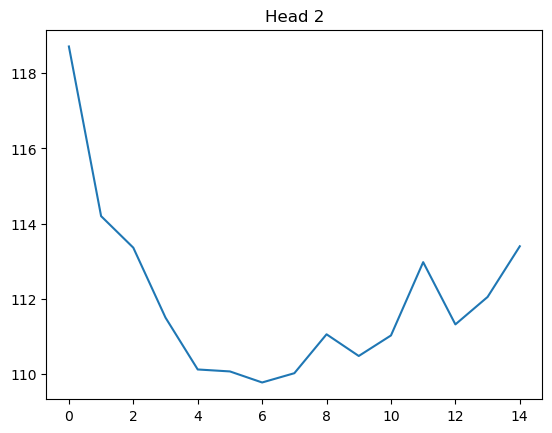

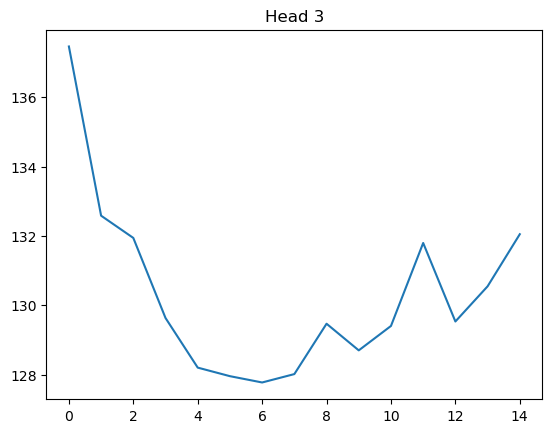

In [58]:
with open('../results/train_res/w2_test_MSE_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()  

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()

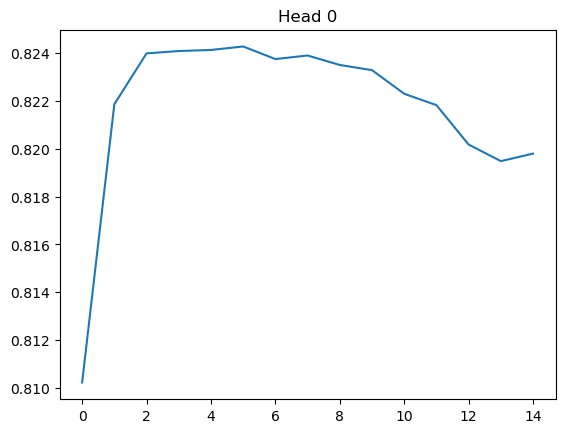

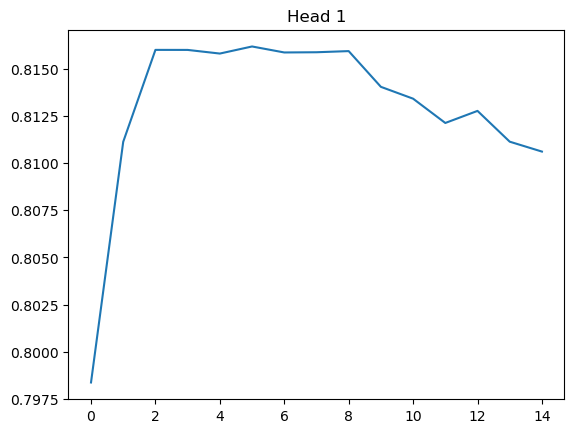

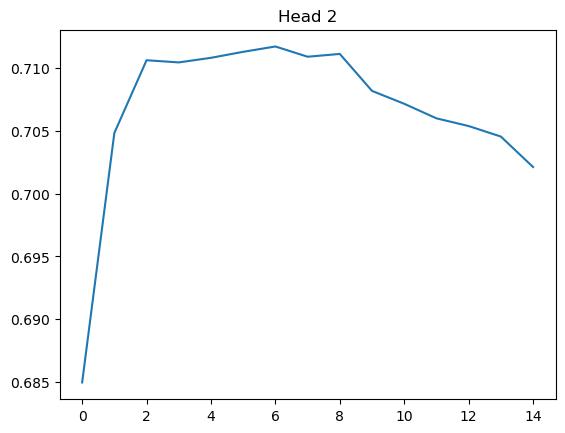

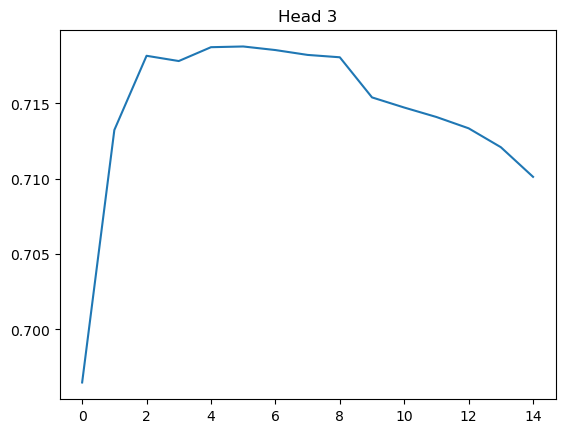

In [51]:
with open('../results/train_res/wbias_corr_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()  

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()

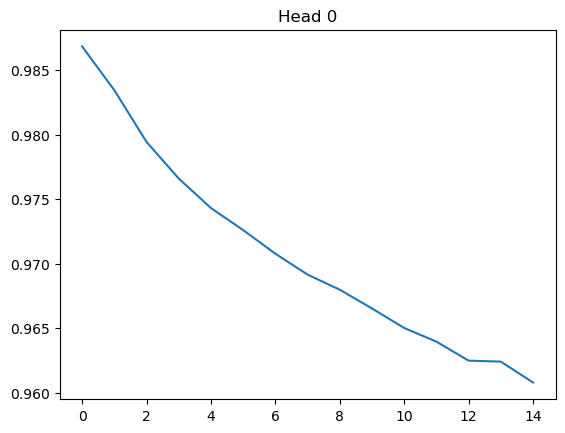

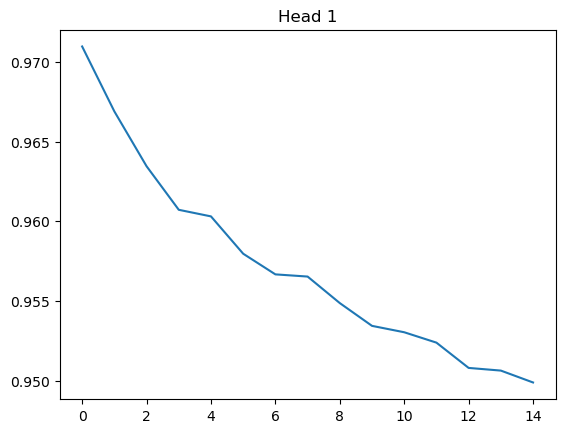

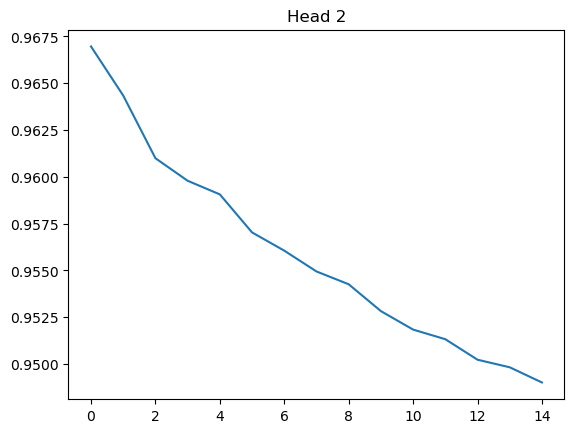

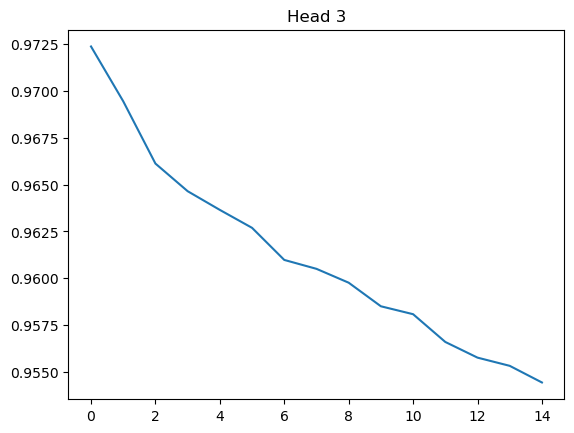

In [107]:
with open('../results/train_res/wbias_jsd_1e-3.pkl', 'rb') as file:
    loss = CPU_Unpickler(file).load()  

loss = torch.stack(loss, dim=1)
loss.shape

for i in range(0,loss.shape[0]):
    plt.plot(loss[i,:])
    plt.title("Head " + str(i))
    plt.show()

# Create synthetic sequences with TF motif

In [ ]:
import pandas as pd
import numpy as np
import pickle
import math

from data_processing.utils_data_preprocessing import encode_sequence

def generate_motif(motif_file, rng):
    #Load the pw TF motif
    motif = pd.read_excel(motif_file, index_col=0, header=None)  
    motif = motif/motif.sum(axis=0)

    #Generate seq using the prob at each nuclotide

    df_selections = pd.DataFrame(
        data=rng.multinomial(n=1, pvals=(motif).transpose()),
        columns=motif.index).idxmax(axis=1)

    gen_motif = df_selections.str.cat()
        
    return gen_motif

#https://stackoverflow.com/questions/66622025/python-generate-random-dna-sequencing-with-known-gc-percent
def generate_seq(GC_content, motif, len_seq, pred_len):
    #Randomly generate a DNA sequence with given GC content and length
    n = round(GC_content * len_seq)
    GC_nucl = list(set('GC'))
    AT_nucl = list(set('AT'))

    seq = [np.random.choice(GC_nucl) for _ in range(n)]
    seq += [np.random.choice(AT_nucl) for _ in range(len_seq - n)]
    np.random.shuffle(seq)
    seq = ''.join(seq)

    #Insert randomly motif in sequence
    insert_idx = int(np.random.randint(low=(math.ceil(len_seq - pred_len)/2), 
                                       high = (math.ceil(len_seq - pred_len)/2) + pred_len, size=1))
    seq = seq[:insert_idx] + motif + seq[insert_idx:]

    return seq, insert_idx
    

CTCF_file = '../data/CTCF.xlsx'
MYOD_file = '../data/MYOD.xlsx'
Tn5_file = '../data/Tn5.xlsx'

rng = np.random.default_rng()

motif = generate_motif(CTCF_file, rng)
seq, insert_idx = generate_seq(0.41, motif, 4096 - len(motif), 1024)

print(insert_idx)
(seq.count('G') + seq.count('C'))/len(seq)


2206


0.41015625

In [ ]:
motif_files, n = ['../data/CTCF.xlsx', '../data/MYOD.xlsx', '../data/Tn5.xlsx'], 2
rng = np.random.default_rng(42)

syn_seq, idx_motif = [], []
for f in motif_files:
    for _ in range(n):
        motif = generate_motif(f, rng)
        seq, idx = generate_seq(0.41, motif, 4096 - len(motif), 1024)

        syn_seq.append(seq)
        idx_motif.append(idx)

with open('../data/synthetic_sequences.pkl', 'wb') as file:
        pickle.dump(syn_seq, file)

with open('../data/synthetic_sequences_idx.pkl', 'wb') as file:
        pickle.dump(idx_motif, file)        


# Compute importance score of nucleotide using shap

In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from interpretation.interpret import compute_importance_score_c_type, compute_importance_score_bias, visualize_sequence_imp
from models.models import CATAC2, CATAC_w_bias
import torch

In [ ]:
path_model = '../results/train_res/wbias_model_1e-3.pkl'
path_seq = '../data/synthetic_sequences.pkl'

all_c_type = ['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CATAC2(nb_conv=8, nb_filters=64, first_kernel=21, 
                      rest_kernel=3, out_pred_len=1024, 
                      nb_pred=4)
        
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))

seq, shap_score, proj_score = compute_importance_score_c_type(model, path_seq, device, "Somite", all_c_type)

### With tn5 bias 

In [90]:
path_model = '../results/train_res/wbias_model_1e-3.pkl'
path_model_bias = "../data/Tn5_NN_model.h5"
path_seq = '../data/synthetic_sequences.pkl'

all_c_type = ['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CATAC_w_bias(nb_conv=8, nb_filters=64, first_kernel=21, 
                      rest_kernel=3, out_pred_len=1024, 
                      nb_pred=4)

model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))
seq, shap_score, proj_score = compute_importance_score_bias(model, path_model_bias, path_seq, device, "Somite", all_c_type)


/Applications/anaconda3/envs/LeKira/lib/python3.10/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


[[[ 0.00000000e+00 -3.74860996e-08 -7.05525395e-07 ...  1.71374803e-10
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.30446134e-10
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.32016940e-08 -8.16186639e-06 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  ...
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]]]


In [54]:
with open('../data/synthetic_sequences_idx.pkl', 'rb') as file:
    idx = pickle.load(file)
idx

[1710, 2206, 2499, 2279, 2469, 1826]

Scores for example 0


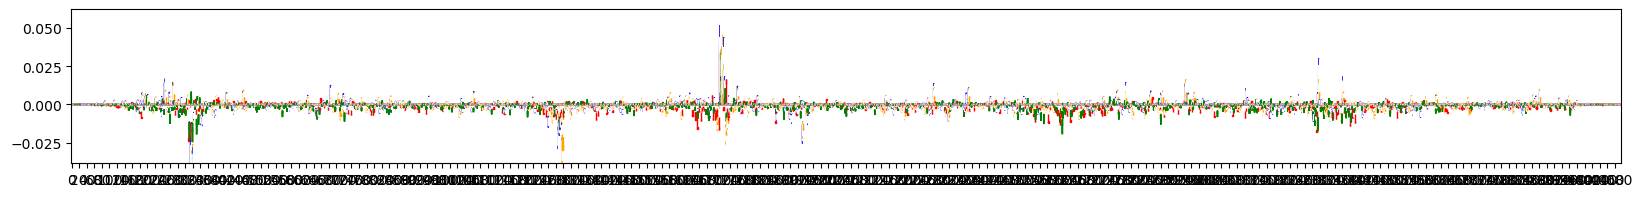

Scores for example 1


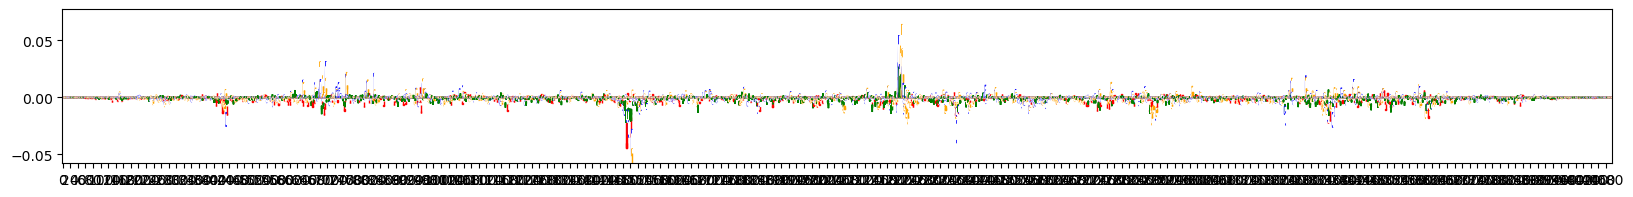

Scores for example 2


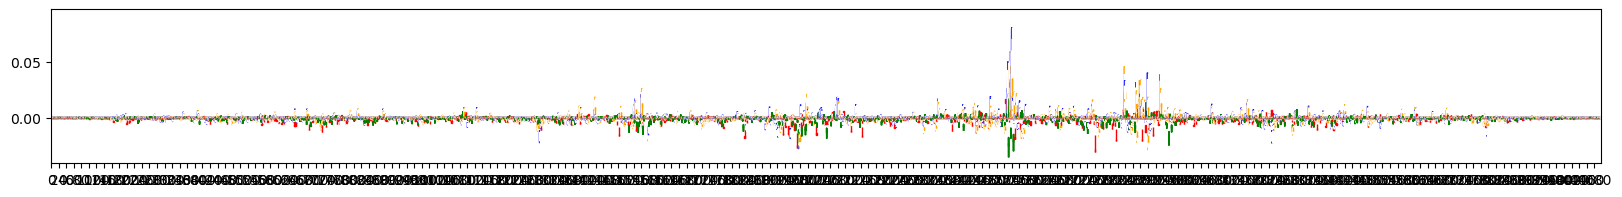

Scores for example 3


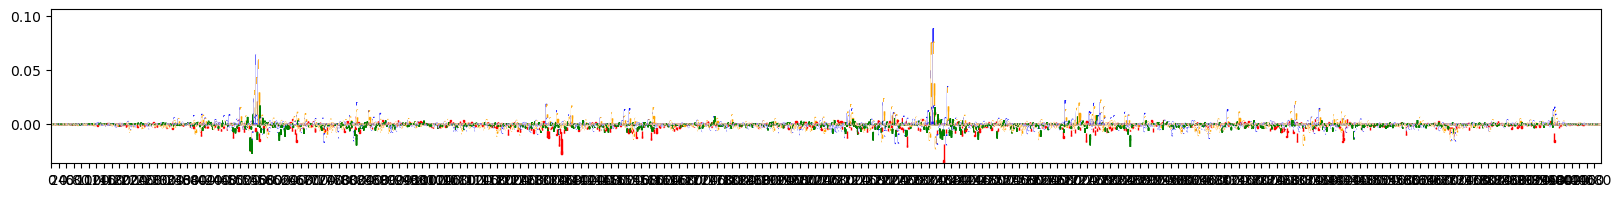

Scores for example 4


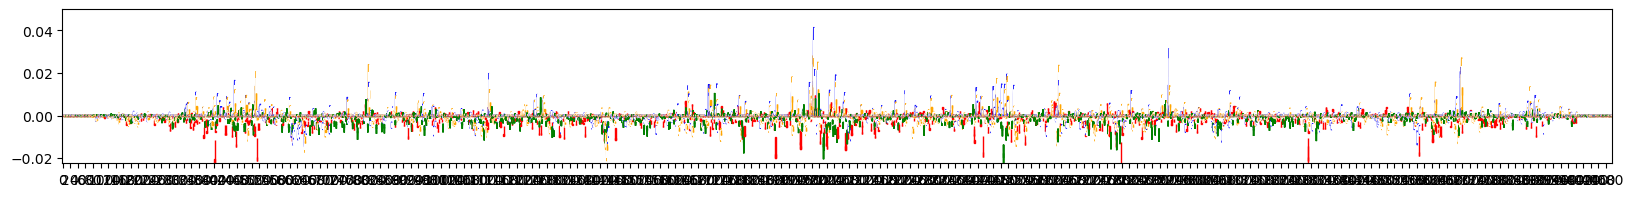

Scores for example 5


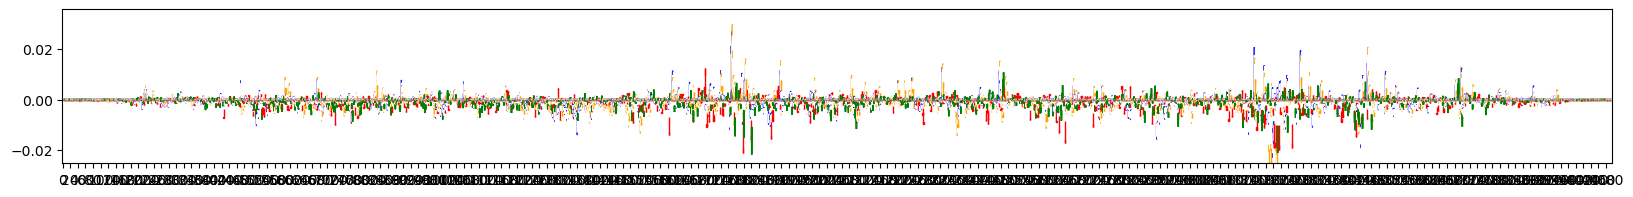

In [10]:
visualize_sequence_imp(proj_score[:,:4,:] ,0, 4096)

Scores for example 0


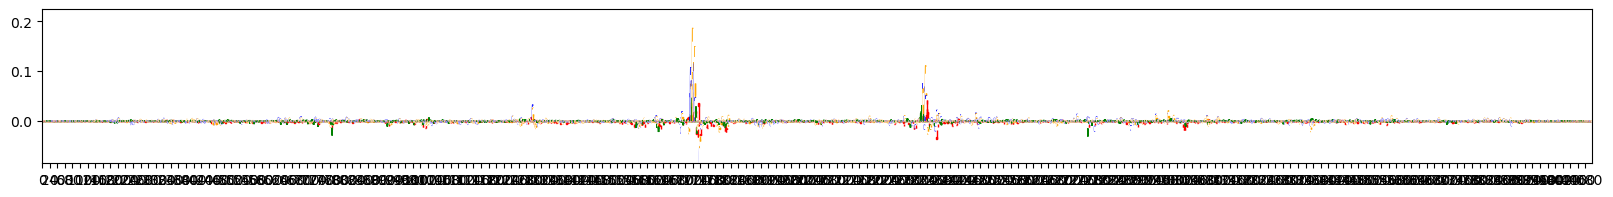

Scores for example 1


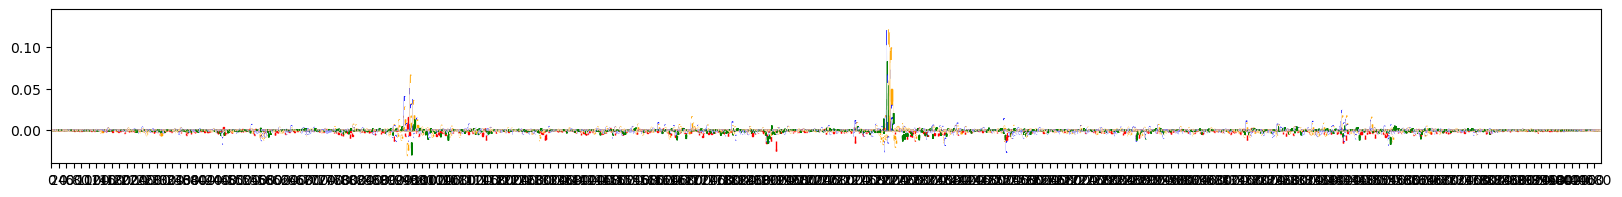

Scores for example 2


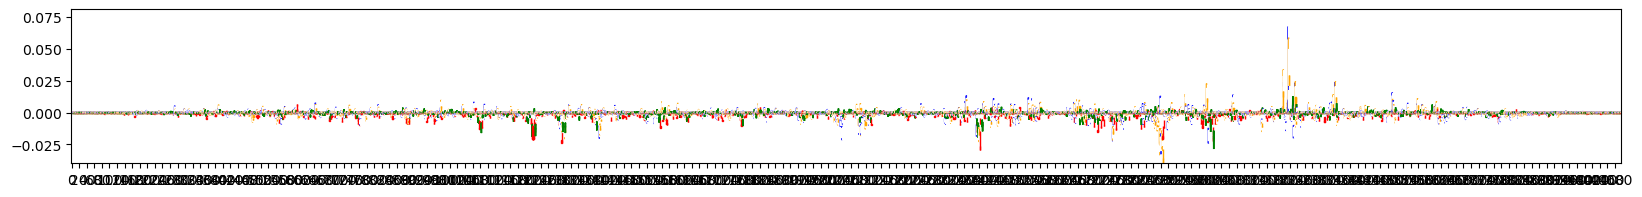

Scores for example 3


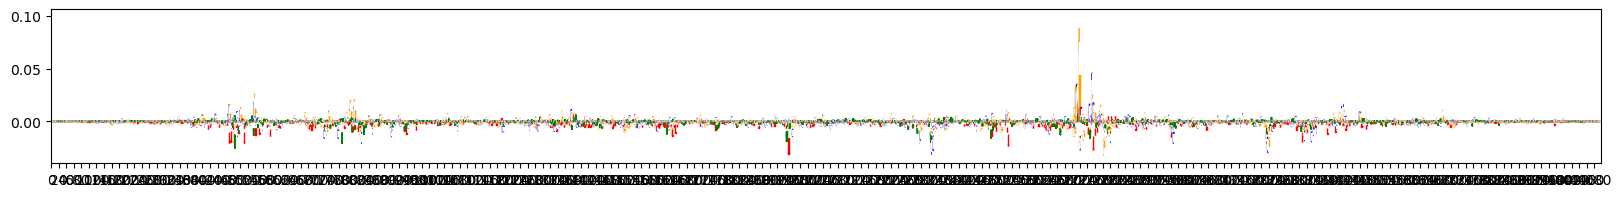

Scores for example 4


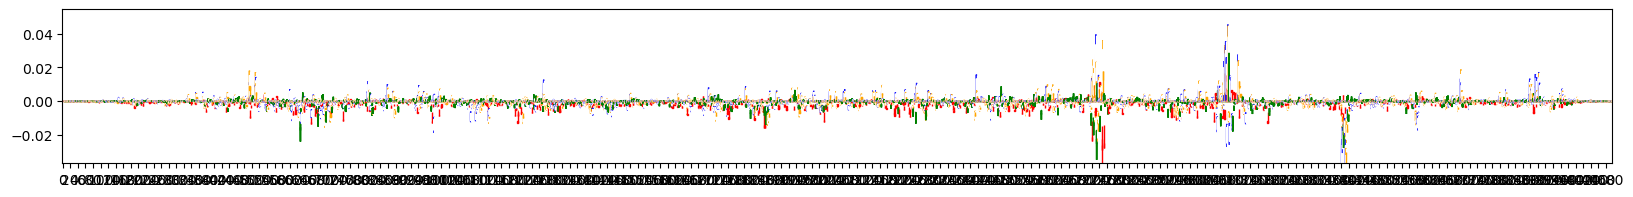

Scores for example 5


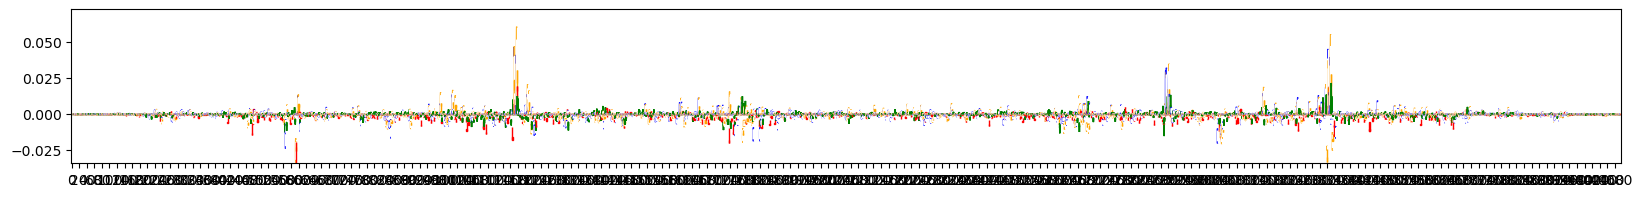

In [91]:
visualize_sequence_imp(proj_score[:,:4,:] ,0, 4096)

Scores for example 0


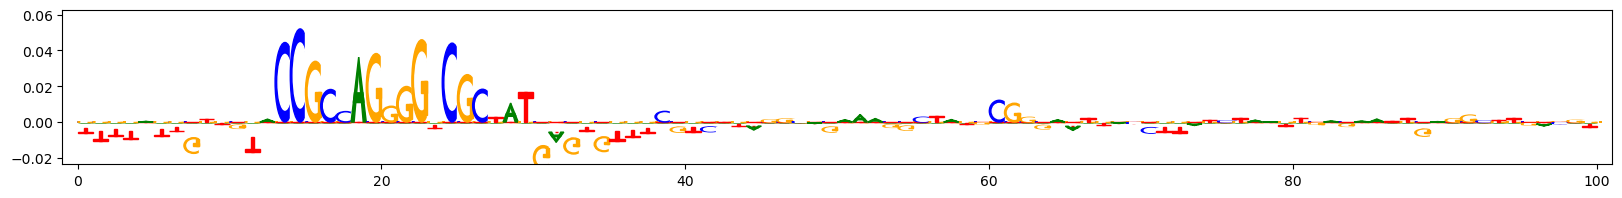

In [18]:
visualize_sequence_imp(proj_score[[0],:4,:] ,1700, 1800)

Scores for example 0


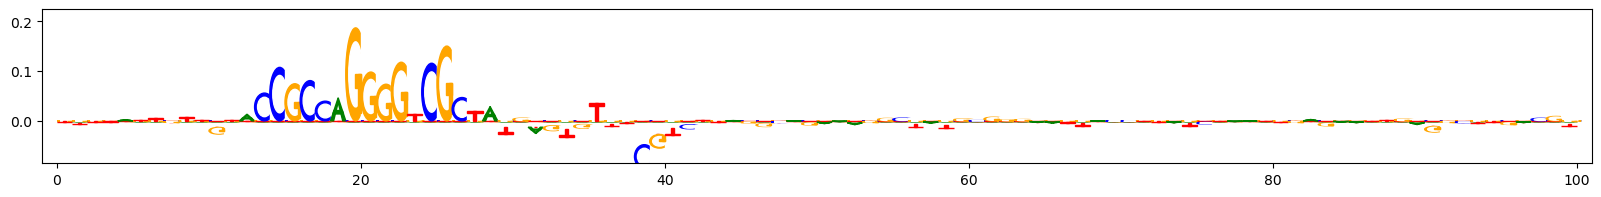

In [92]:
visualize_sequence_imp(proj_score[[0],:4,:] ,1700, 1800)

Scores for example 0


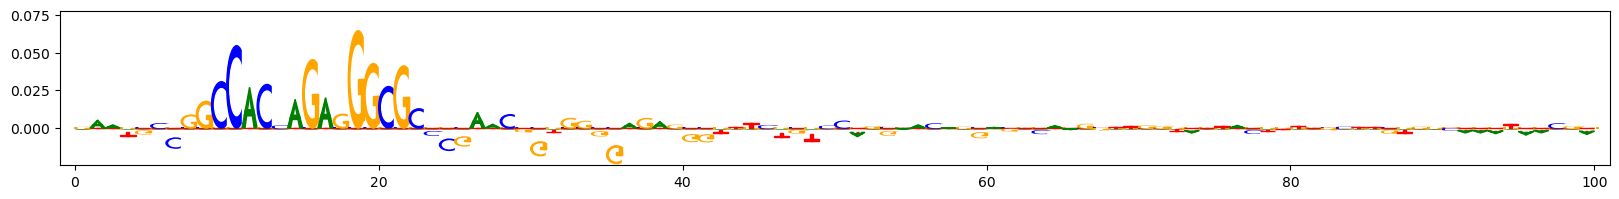

In [19]:
visualize_sequence_imp(proj_score[[1],:4,:] ,2200, 2300)


Scores for example 0


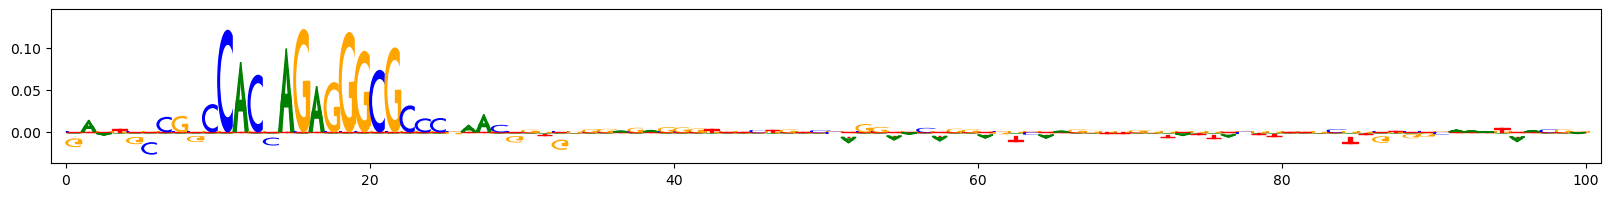

In [93]:
visualize_sequence_imp(proj_score[[1],:4,:] ,2200, 2300)


Scores for example 0


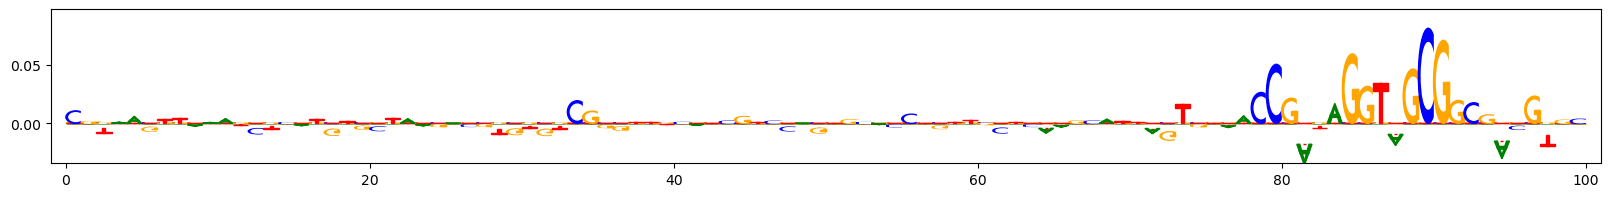

In [13]:
visualize_sequence_imp(proj_score[[2],:4,:] ,2450, 2550)


Scores for example 0


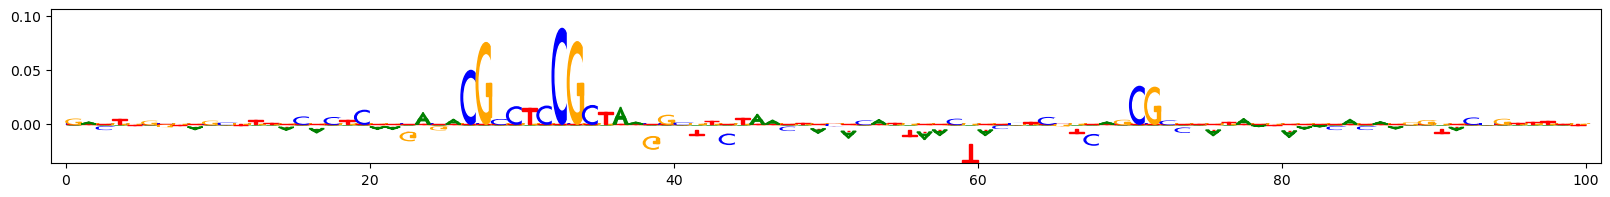

In [20]:
visualize_sequence_imp(proj_score[[3],:4,:] ,2300, 2400)


Scores for example 0


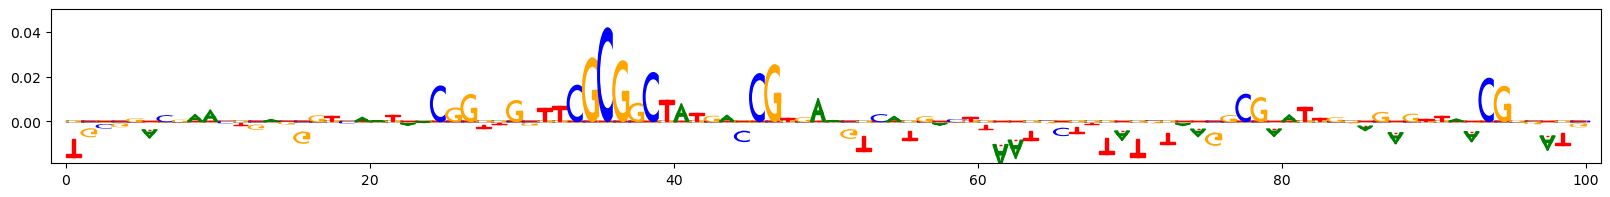

In [26]:
visualize_sequence_imp(proj_score[[4],:4,:] ,1950, 2050)


Scores for example 0


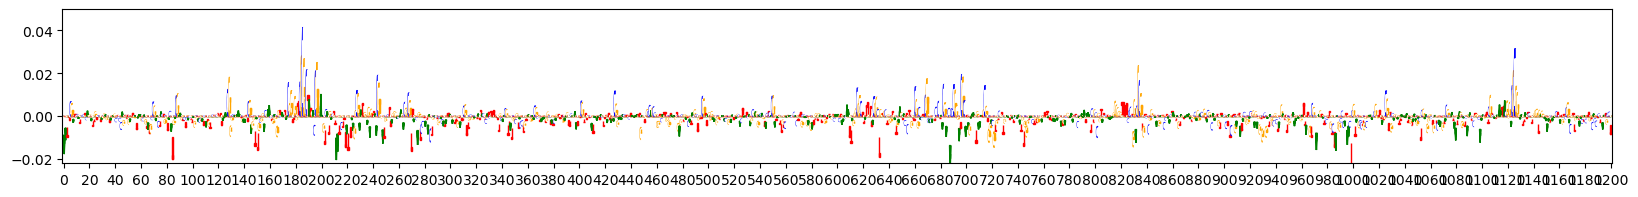

In [24]:
visualize_sequence_imp(proj_score[[5],:4,:] ,1800, 3000)


In [5]:
from interpretation.interpret import compute_integrated_gradient, visualize_sequence_imp
from models.models import CATAC2
import torch

In [134]:
import pandas as pd

path_seq = '../data/synthetic_sequences.pkl'

seq = pd.Series(pd.read_pickle(path_seq))
seq[0][1700:1800]

'TTTTATTGTTGTACCGCCAGGGGTCGCTATGAGTGTTTCGTCTTAGGCAGAAAGGCTATGCGGGAATTACCTTATCTAATTGAGAATTGAGGCTTGACGT'

In [61]:
path_model = '../results/train_res/w/w_model_1e-3.pkl'
path_seq = '../data/synthetic_sequences.pkl'

all_c_type = ['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CATAC2(nb_conv=8, nb_filters=64, first_kernel=21, 
                      rest_kernel=3, out_pred_len=1024, 
                      nb_pred=4)
        
model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu')))

seq, int_grad, proj_score = compute_integrated_gradient(model, path_seq, device, "Somite", all_c_type)

Scores for example 0


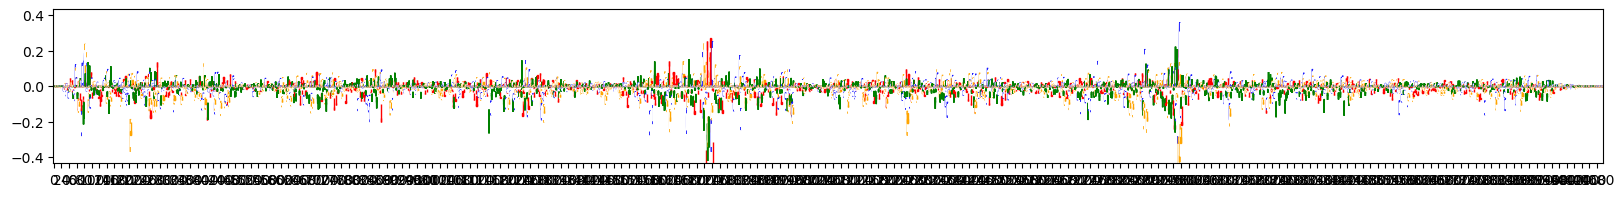

Scores for example 1


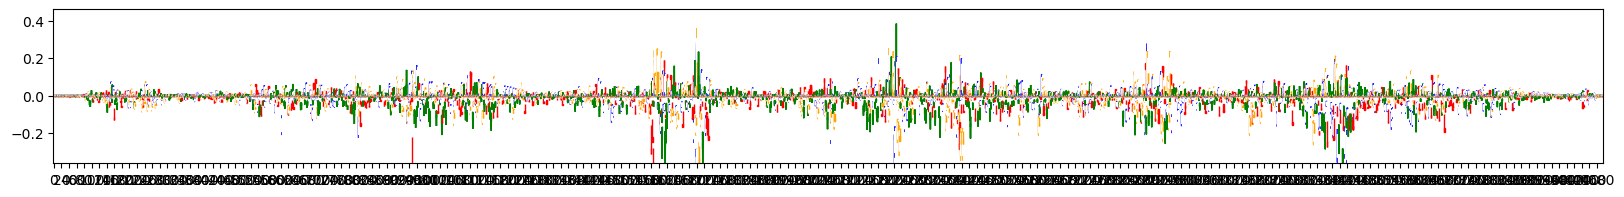

Scores for example 2


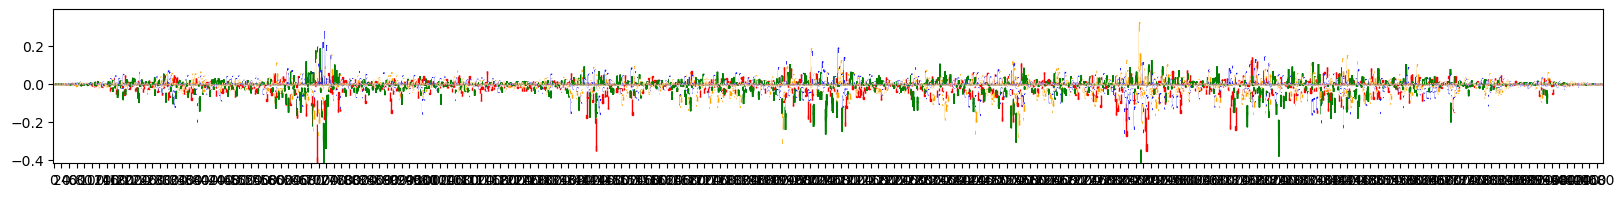

Scores for example 3


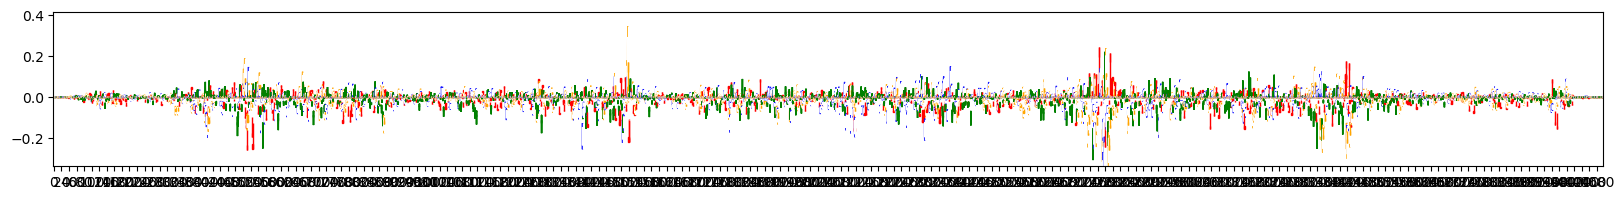

Scores for example 4


KeyboardInterrupt: 

In [62]:
visualize_sequence_imp(proj_score[:,:4,:] ,0, 4096)

MEMORY 1.154031616
On task task
Computing windowed sums on original
Generating null dist


peak(mu)= -1.2771668657820673e-23
Computing threshold
For increasing = True , the minimum IR precision was 0.5000000000000168 occurring at 0.0 implying a frac_neg of 1.000000000000067
To be conservative, adjusted frac neg is 1.0
For increasing = False , the minimum IR precision was 0.5000000000000083 occurring at -1.2576745200831851e-17 implying a frac_neg of 1.0000000000000333
To be conservative, adjusted frac neg is 1.0
Thresholds from null dist were -1.2576745200831851e-17  and  1.5504091066542713e-17 with frac passing 8.177952240758914e-05
Passing windows frac was 8.177952240758914e-05 , which is below  0.03 ; adjusting
Final raw thresholds are -1.839289693315342e-18  and  1.839289693315342e-18
Final transformed thresholds are -0.9699869152764148  and  0.9699869152764148


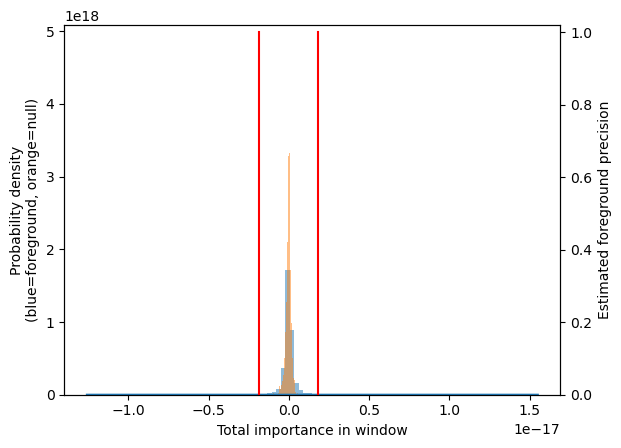

Got 66 coords
After resolving overlaps, got 66 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9698869152764148
MEMORY 1.15816448
66 identified in total
2 activity patterns with support >= 1 out of 2 possible patterns
Metacluster sizes:  [35, 31]
Idx to activities:  {0: '1', 1: '-1'}
MEMORY 1.15816448
On metacluster 1
Metacluster size 31
Relevant tasks:  ('task',)
Relevant signs:  (-1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 31
(Round 1) Computing coarse affmat
MEMORY 1.0317824
Beginning embedding computation
MEMORY 1.0317824
At the beginning of embedding call
MEMORY 1.0317824
before computing embeddings fwd
MEMORY 1.031786496


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    7.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 1.032527872


[Parallel(n_jobs=4)]: Done  24 out of  31 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  31 out of  31 | elapsed:    0.5s finished


after computing embeddings rev
MEMORY 1.032536064
before computing sparse embeddings fwd
MEMORY 1.032536064
Constructing csr matrix...
csr matrix made in 0.014219999313354492 s
after computing sparse embeddings fwd
MEMORY 1.031622656
before computing sparse embeddings rev
MEMORY 1.031622656
Constructing csr matrix...
csr matrix made in 0.007025957107543945 s
after computing sparse embeddings rev
MEMORY 1.031794688
Finished embedding computation in 8.3 s
MEMORY 1.031401472
Starting affinity matrix computations
MEMORY 1.031401472
Batching in slices of size 31


100%|██████████| 1/1 [00:04<00:00,  4.11s/it]

Finished affinity matrix computations in 4.14 s
MEMORY 1.01009408


(Round 1) Computed coarse affmat
MEMORY 1.015496704
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 1.015496704
Launching nearest neighbors affmat calculation job
MEMORY 1.01597184
Parallel runs completed
MEMORY 1.0161152
Job completed in: 0.57 s
MEMORY 1.016119296
Launching nearest neighbors affmat calculation job
MEMORY 1.016037376
Parallel runs completed
MEMORY 1.016111104
Job completed in: 0.48 s
MEMORY 1.016111104
(Round 1) Computed affinity matrix on nearest neighbors in 1.35 s
MEMORY 1.015734272
Filtered down to 15 of 31
(Round 1) Retained 15 rows out of 31 after filtering
MEMORY 1.015861248
(Round 1) Computing density adapted affmat
MEMORY 1.015873536
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 1.015959552
Beginning preprocessing + Leiden
Affmat shape: 15


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.9s


Quality: 0.6009602731009118
Got 15 clusters after round 1
Counts:
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1}
MEMORY 1.01605376
(Round 1) Aggregating seqlets in each cluster
MEMORY 1.016057856
Aggregating for cluster 0 with 1 seqlets
MEMORY 1.016057856
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 1 with 1 seqlets
MEMORY 1.016061952
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 2 with 1 seqlets
MEMORY 1.016061952
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 3 with 1 seqlets
MEMORY 1.016061952
Trimming eliminated 0 seqlets out of 1
Dropping cluster 3 with 1 seqlets due to sign disagreement
Aggregating for cluster 4 with 1 seqlets
MEMORY 1.016061952
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 5 with 1 seqlets
MEMORY 1.016061952
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 6 with 1 seqlets
MEMORY 1.016061952
Trimming eliminated 0 seqlets out of 1
Agg

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   23.7s finished


Trimming eliminated 0 seqlets out of 1
(Round 2) num seqlets: 14
(Round 2) Computing coarse affmat
MEMORY 1.016061952
Beginning embedding computation
MEMORY 1.016061952
At the beginning of embedding call
MEMORY 1.016061952
before computing embeddings fwd
MEMORY 1.016696832


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 out of  14 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 1.0174464


[Parallel(n_jobs=4)]: Done  14 out of  14 | elapsed:    0.4s finished


after computing embeddings rev
MEMORY 1.0174464
before computing sparse embeddings fwd
MEMORY 1.0174464
Constructing csr matrix...
csr matrix made in 0.004362821578979492 s
after computing sparse embeddings fwd
MEMORY 1.01746688
before computing sparse embeddings rev
MEMORY 1.01746688
Constructing csr matrix...
csr matrix made in 0.004103899002075195 s
after computing sparse embeddings rev
MEMORY 1.017524224
Finished embedding computation in 1.16 s
MEMORY 1.017442304
Starting affinity matrix computations
MEMORY 1.017442304
Batching in slices of size 14


100%|██████████| 1/1 [00:02<00:00,  2.62s/it]

Finished affinity matrix computations in 2.63 s
MEMORY 1.017450496


(Round 2) Computed coarse affmat
MEMORY 1.017217024
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 1.017217024
Launching nearest neighbors affmat calculation job
MEMORY 1.01722112
Parallel runs completed
MEMORY 1.016041472
Job completed in: 0.6 s
MEMORY 1.016041472
Launching nearest neighbors affmat calculation job
MEMORY 1.015996416
Parallel runs completed
MEMORY 1.016041472
Job completed in: 0.4 s
MEMORY 1.016041472
(Round 2) Computed affinity matrix on nearest neighbors in 1.25 s
MEMORY 1.015816192
Not applying filtering for rounds above first round
MEMORY 1.015816192
(Round 2) Computing density adapted affmat
MEMORY 1.015816192
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 1.015816192
Beginning preprocessing + Leiden
Affmat shape: 14


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.2s


Quality: 0.7121899867730674
Got 14 clusters after round 2
Counts:
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1}
MEMORY 1.015820288
(Round 2) Aggregating seqlets in each cluster
MEMORY 1.015820288
Aggregating for cluster 0 with 1 seqlets
MEMORY 1.015820288
Trimming eliminated 0 seqlets out of 1
Dropping cluster 0 with 1 seqlets due to sign disagreement
Aggregating for cluster 1 with 1 seqlets
MEMORY 1.015820288
Trimming eliminated 0 seqlets out of 1
Dropping cluster 1 with 1 seqlets due to sign disagreement
Aggregating for cluster 2 with 1 seqlets
MEMORY 1.015820288
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 3 with 1 seqlets
MEMORY 1.015820288
Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 4 with 1 seqlets
MEMORY 1.015820288
Trimming eliminated 0 seqlets out of 1
Dropping cluster 4 with 1 seqlets due to sign disagreement
Aggregating for cluster 5 with 1 seqlets
MEMORY 1.015820288
Trimming eliminated 0 seqlets

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   24.1s finished


Numbers for each pattern pre-subsample: [1, 1, 1, 1, 1]
Numbers after subsampling: [1, 1, 1, 1, 1]
Computing sims for pattern 0
Computed sims for pattern 0 in 0.12874317169189453 s
Computing sims for pattern 1
Computed sims for pattern 1 in 0.13371515274047852 s
Computing sims for pattern 2
Computed sims for pattern 2 in 0.13101887702941895 s
Computing sims for pattern 3
Computed sims for pattern 3 in 0.13196706771850586 s
Computing sims for pattern 4
Computed sims for pattern 4 in 0.11984395980834961 s
Cluster sizes
[1 1 1 1 1]
Cross-contamination matrix:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Pattern-to-pattern sim matrix:
[[1.   0.23 0.59 0.21 0.55]
 [0.23 1.   0.41 0.29 0.2 ]
 [0.59 0.41 1.   0.28 0.48]
 [0.21 0.29 0.28 1.   0.45]
 [0.55 0.2  0.48 0.45 1.  ]]
Got 5 patterns after merging
MEMORY 1.01584896
Performing filtering
MEMORY 1.01584896
Got 0 patterns after filtering
MEMORY 1.01584896
Total time taken is 70.32s
MEMORY 1.015

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  28 out of  35 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 1.017208832


[Parallel(n_jobs=4)]: Done  28 out of  35 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed:    0.6s finished


after computing embeddings rev
MEMORY 1.017212928
before computing sparse embeddings fwd
MEMORY 1.017212928
Constructing csr matrix...
csr matrix made in 0.008228063583374023 s
after computing sparse embeddings fwd
MEMORY 1.01783552
before computing sparse embeddings rev
MEMORY 1.01783552
Constructing csr matrix...
csr matrix made in 0.0073812007904052734 s
after computing sparse embeddings rev
MEMORY 1.018003456
Finished embedding computation in 1.62 s
MEMORY 1.018003456
Starting affinity matrix computations
MEMORY 1.018003456
Batching in slices of size 35


100%|██████████| 1/1 [00:03<00:00,  3.25s/it]

Finished affinity matrix computations in 3.27 s
MEMORY 0.944214016


(Round 1) Computed coarse affmat
MEMORY 0.943988736
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 0.943988736
Launching nearest neighbors affmat calculation job
MEMORY 0.944013312
Parallel runs completed
MEMORY 0.94390272
Job completed in: 0.56 s
MEMORY 0.94390272
Launching nearest neighbors affmat calculation job
MEMORY 0.943808512
Parallel runs completed
MEMORY 0.943853568
Job completed in: 0.53 s
MEMORY 0.943853568
(Round 1) Computed affinity matrix on nearest neighbors in 1.43 s
MEMORY 0.943398912
Filtered down to 29 of 35
(Round 1) Retained 29 rows out of 35 after filtering
MEMORY 0.943398912
(Round 1) Computing density adapted affmat
MEMORY 0.943398912
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 1) Computing clustering
MEMORY 0.943407104
Beginning preprocessing + Leiden
Affmat shape: 29


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   19.3s


Quality: 0.16201315204467248
Quality: 0.16221573426670152
Quality: 0.16221573426670155
Quality: 0.16238370015837147
Got 12 clusters after round 1
Counts:
{6: 2, 0: 4, 8: 2, 11: 1, 3: 3, 1: 4, 7: 2, 4: 3, 2: 3, 5: 2, 9: 2, 10: 1}
MEMORY 0.9434112
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.9434112
Aggregating for cluster 0 with 4 seqlets
MEMORY 0.9434112
Trimming eliminated 0 seqlets out of 4
Aggregating for cluster 1 with 4 seqlets
MEMORY 0.943419392
Trimming eliminated 0 seqlets out of 4
Aggregating for cluster 2 with 3 seqlets
MEMORY 0.943419392
Trimming eliminated 0 seqlets out of 3
Aggregating for cluster 3 with 3 seqlets
MEMORY 0.943419392
Trimming eliminated 0 seqlets out of 3
Aggregating for cluster 4 with 3 seqlets
MEMORY 0.943419392
Trimming eliminated 0 seqlets out of 3
Aggregating for cluster 5 with 2 seqlets
MEMORY 0.943419392
Trimming eliminated 0 seqlets out of 2
Aggregating for cluster 6 with 2 seqlets
MEMORY 0.943419392
Trimming eliminated 0 seqlets out of 2


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   23.2s finished


Trimming eliminated 0 seqlets out of 1
(Round 2) num seqlets: 28
(Round 2) Computing coarse affmat
MEMORY 0.943419392
Beginning embedding computation
MEMORY 0.943419392
At the beginning of embedding call
MEMORY 0.943419392
before computing embeddings fwd
MEMORY 0.943722496


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  21 out of  28 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


after computing embeddings fwd
MEMORY 0.943915008


[Parallel(n_jobs=4)]: Done  21 out of  28 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=4)]: Done  28 out of  28 | elapsed:    0.7s finished


after computing embeddings rev
MEMORY 0.9437184
before computing sparse embeddings fwd
MEMORY 0.9437184
Constructing csr matrix...
csr matrix made in 0.01196908950805664 s
after computing sparse embeddings fwd
MEMORY 0.944201728
before computing sparse embeddings rev
MEMORY 0.944201728
Constructing csr matrix...
csr matrix made in 0.007946014404296875 s
after computing sparse embeddings rev
MEMORY 0.944390144
Finished embedding computation in 1.82 s
MEMORY 0.944390144
Starting affinity matrix computations
MEMORY 0.944390144
Batching in slices of size 28


100%|██████████| 1/1 [00:02<00:00,  2.84s/it]

Finished affinity matrix computations in 2.86 s
MEMORY 0.944009216


(Round 2) Computed coarse affmat
MEMORY 0.943177728
(Round 2) Computing affinity matrix on nearest neighbors
MEMORY 0.943177728
Launching nearest neighbors affmat calculation job
MEMORY 0.943177728
Parallel runs completed
MEMORY 0.943316992
Job completed in: 0.75 s
MEMORY 0.943321088
Launching nearest neighbors affmat calculation job
MEMORY 0.94324736
Parallel runs completed
MEMORY 0.94332928
Job completed in: 0.68 s
MEMORY 0.94332928
(Round 2) Computed affinity matrix on nearest neighbors in 1.87 s
MEMORY 0.942903296
Not applying filtering for rounds above first round
MEMORY 0.942903296
(Round 2) Computing density adapted affmat
MEMORY 0.942903296
Symmetrizing nearest neighbors
Computing betas for density adaptation
Computing normalizing denominators
(Round 2) Computing clustering
MEMORY 0.942903296
Beginning preprocessing + Leiden
Affmat shape: 28


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   21.3s


Quality: 0.20349328055484736
Got 16 clusters after round 2
Counts:
{0: 4, 8: 2, 9: 1, 1: 3, 10: 1, 6: 2, 12: 1, 11: 1, 5: 2, 3: 2, 13: 1, 4: 2, 2: 2, 14: 1, 15: 1, 7: 2}
MEMORY 0.942903296
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.942903296
Aggregating for cluster 0 with 4 seqlets
MEMORY 0.942903296
Trimming eliminated 0 seqlets out of 4
Aggregating for cluster 1 with 3 seqlets
MEMORY 0.942903296
Trimming eliminated 0 seqlets out of 3
Aggregating for cluster 2 with 2 seqlets
MEMORY 0.942903296
Trimming eliminated 0 seqlets out of 2
Aggregating for cluster 3 with 2 seqlets
MEMORY 0.942903296
Trimming eliminated 0 seqlets out of 2
Aggregating for cluster 4 with 2 seqlets
MEMORY 0.942903296
Trimming eliminated 0 seqlets out of 2
Aggregating for cluster 5 with 2 seqlets
MEMORY 0.942903296
Skipped 1 due to duplicates
Trimming eliminated 0 seqlets out of 1
Dropping cluster 5 with 1 seqlets due to sign disagreement
Aggregating for cluster 6 with 2 seqlets
MEMORY 0.942903296
Trimm

[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   24.4s finished


Trimming eliminated 0 seqlets out of 1
Aggregating for cluster 15 with 1 seqlets
MEMORY 0.942903296
Trimming eliminated 0 seqlets out of 1
Got 13 clusters
Splitting into subclusters...
MEMORY 0.942903296
Inspecting pattern 0 for spurious merging
Inspecting pattern 1 for spurious merging
Inspecting pattern 2 for spurious merging
Inspecting pattern 3 for spurious merging
Inspecting pattern 4 for spurious merging
Inspecting pattern 5 for spurious merging
Inspecting pattern 6 for spurious merging
Inspecting pattern 7 for spurious merging
Inspecting pattern 8 for spurious merging
Inspecting pattern 9 for spurious merging
Inspecting pattern 10 for spurious merging
Inspecting pattern 11 for spurious merging
Inspecting pattern 12 for spurious merging
Merging on 13 clusters
MEMORY 0.942903296
On merging iteration 1
Numbers for each pattern pre-subsample: [4, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
Numbers after subsampling: [4, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1]
Computing sims for pattern 0
Comput

In [123]:
import h5py
import numpy as np
%matplotlib inline
import modisco
import torch

contrib_scores = {"task": list(np.array(proj_score[:,:4,:].permute(0,2,1)))}
hypothetical_contribs = {"task": list(np.array(int_grad.permute(0,2,1)))}
one_hot = list(np.array(seq[:,:4,:].permute(0,2,1)))

null_per_pos_scores = modisco.coordproducers.LaplaceNullDist(num_to_samp=5000)
tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(min_metacluster_size=1)(
                 task_names=["task"],
                 contrib_scores= contrib_scores,
                 hypothetical_contribs=hypothetical_contribs,
                 one_hot=one_hot,
                 null_per_pos_scores = null_per_pos_scores)

In [131]:
![[ -e results.hdf5 ]] 
grp = h5py.File("results.hdf5", 'w')
tfmodisco_results.save_hdf5(grp)
grp.close()

Metaclusters heatmap


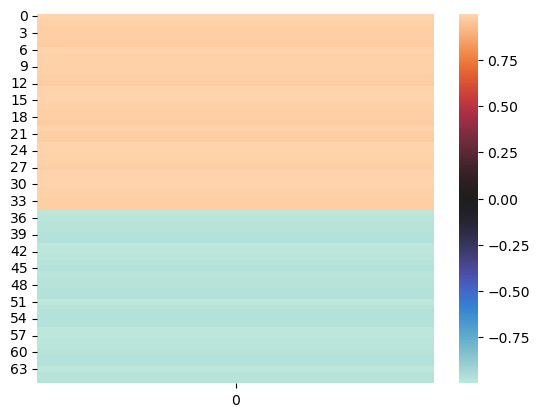

metacluster_0
activity pattern: [1]
No motifs found for this activity pattern
metacluster_1
activity pattern: [-1]
No motifs found for this activity pattern


In [133]:
try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3


from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

# Number of parameters

In [ ]:
from models.models import BPNet, CATAC

biasModel =  BPNet(nb_conv=8, nb_filters=64)
model = CATAC(nb_conv=8, nb_filters=64, first_kernel=21, 
                      rest_kernel=3, profile_kernel_size=75, out_pred_len=1024, 
                      nb_pred=24, nb_cell_type_CN = 0)

print("Main model")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Bias model")
print(sum(p.numel() for p in biasModel.parameters() if p.requires_grad))

Main model
208688
Bias model
96770


# Look at track predictions

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!python inspect_pred.py

In [27]:
with open('../results/train_res/true.pkl', 'rb') as file:
    true = pickle.load(file)

with open('../results/train_res/pred.pkl', 'rb') as file:
    pred = pickle.load(file)

<BarContainer object of 1024 artists>

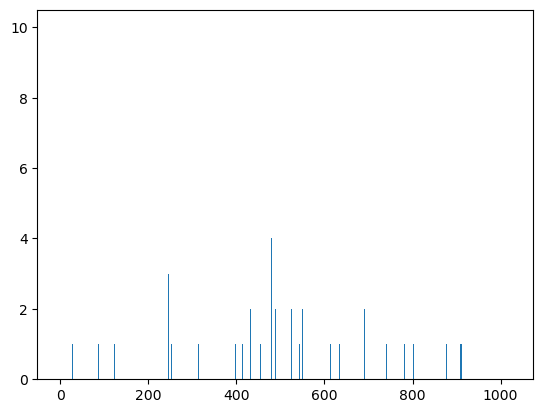

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.bar(x = np.arange(0,1024), height = true[0][50,:,1])

<BarContainer object of 1024 artists>

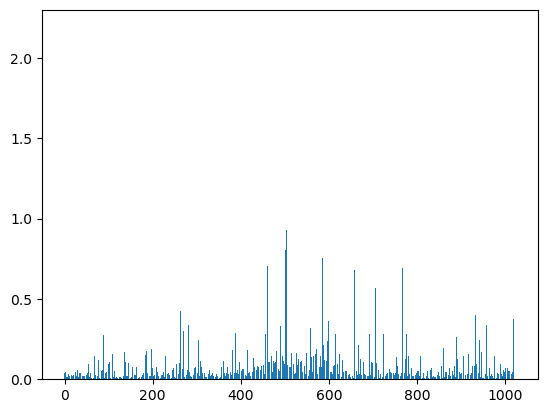

In [37]:
plt.bar(x = np.arange(0,1024), height = pred[1][50,:])

In [33]:
true[0].shape, pred[0].shape

(torch.Size([108, 1024, 4]), torch.Size([108, 1024]))

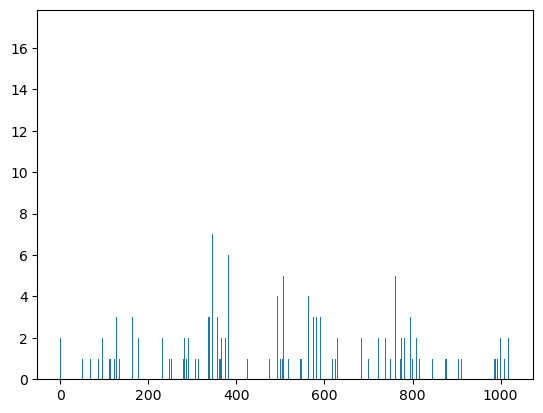

<BarContainer object of 1024 artists>

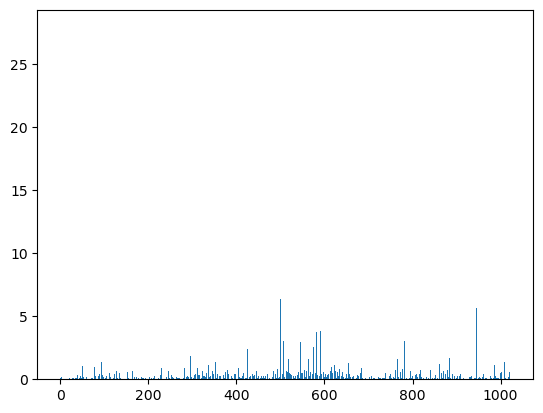

In [36]:
plt.bar(x = np.arange(0,1024), height = true[0][0,:,1])
plt.show()
plt.bar(x = np.arange(0,1024), height = pred[1][0,:])

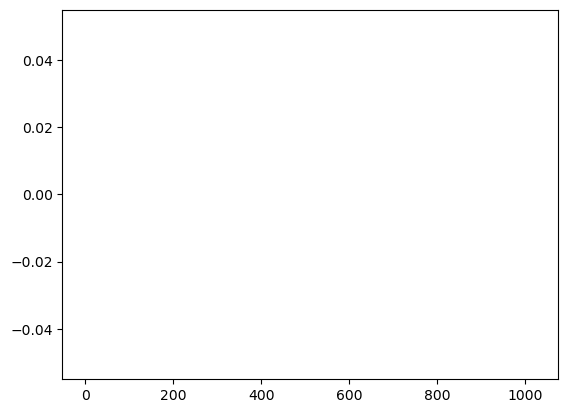

<BarContainer object of 1024 artists>

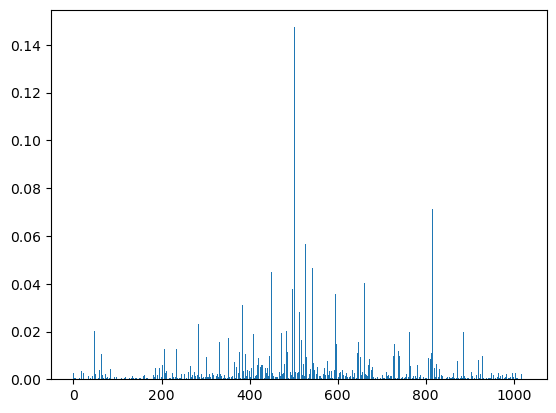

In [40]:
plt.bar(x = np.arange(0,1024), height = true[0][28,:,0])
plt.show()
plt.bar(x = np.arange(0,1024), height = pred[0][28,:])

# Test new model

In [3]:
from models.models import CATAC2
import torch

model  = CATAC2()
input = torch.randn(32, 11, 4096)
tn5_bias  = torch.randn(32, 1024)
 
_, profile, count = model(input)

len(profile), profile[0].shape

(4, torch.Size([32, 1024]))

In [8]:
32/8

4.0

In [59]:
from models.eval_metrics import profile_metrics

tracks = torch.randn(32, 1024).abs()
profile_metrics(tracks, profile[0], [True, True, False, True, True, True, True, True]*4)


tensor(0.1939, grad_fn=<MulBackward0>)

In [4]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch

input = torch.randn(0, 4, 4096)
print(input)
c_type = torch.randn(7)
c_type = c_type.tile((input.shape[-1],1)).permute(1,0)[:,:]

tensor([], size=(0, 4, 4096))


In [2]:
from models.pytorch_datasets import PeaksDataset2
from torch.utils.data import DataLoader

data_dir = "../results/"
time_order = ['D8', 'D12', 'D20', 'D22-15']
chr_test = ['6','13','22']

test_dataset = PeaksDataset2(data_dir + 'peaks_seqtest.pkl', data_dir + 'background_GC_matchedt.pkl',
                                 data_dir + 'ATAC_peakstest.pkl', data_dir + 'ATAC_backgroundtest.pkl', 
                                 chr_test, time_order, 0)
test_dataloader = DataLoader(test_dataset, 64,
                        shuffle=True, num_workers=0)                                

/Users/adorman/Documents/master-thesis/src/models/pytorch_datasets.py:171: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.sequences = pd.concat([self.sequences, pickle.load(file).sample(nb_back)])


In [3]:
test_dataset.ATAC_track = test_dataset.ATAC_track["track"]

In [12]:
import numpy as np

test_dataset.ATAC_track.loc[test_dataset.ATAC_track.isna()] = [np.zeros(1024)] * test_dataset.ATAC_track.isna().sum()

In [14]:
test_dataset.ATAC_track =  np.stack(test_dataset.ATAC_track.values)

: 

In [13]:
test_dataloader = DataLoader(test_dataset, 64,
                        shuffle=True, num_workers=0)  

In [4]:
from models.eval_metrics import ATACloss_KLD
import torch

weight_MSE, weight_KLD = 1, 1
criterion = ATACloss_KLD(weight_MSE= weight_MSE, weight_KLD = weight_KLD)
    
for data in test_dataloader:
    input, tracks, indexes = data
    indexes = torch.stack(indexes)

    """ _, profile, count = model(input)

    #Compute loss for each head
    losses = [criterion(tracks[:,j,:], profile[j], count[j], indexes[j,:]) for j in range(0,len(profile))]
    KLD = torch.stack([loss[1] for loss in losses]).detach();  MSE = torch.stack([loss[2] for loss in losses]).detach()
    loss = torch.stack([loss[0] for loss in losses]).nansum() """

    break

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7faf8769b790>>
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/LeKira/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


------------------
42687665


InvalidIndexError: (slice(42687665, 42687669, None), slice(None, None, None))

# divers

In [6]:
"chr1"[3:]

'1'

In [228]:
import h5py

chr = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','X','Y']
chr = ["chr" + x for x in chr] 

dictionary = {}
with h5py.File("../results/hg38Tn5Bias.h5", "r") as f:
    for key in f.keys():
        if key in chr:
            ds_arr = f[key][()] 
            dictionary[key[3:]] = ds_arr

dictionary["chr1"][10000:10100]

array([4.29590791e-01, 2.21256065e+00, 7.72537738e-02, 2.23639850e-02,
       2.11469810e-02, 5.72008044e-02, 2.60251307e+00, 6.29612017e+00,
       1.40654072e-01, 2.55845468e-02, 2.69870367e-02, 4.73592103e-01,
       3.85945106e+00, 6.59393978e+00, 1.21274255e-01, 1.91201400e-02,
       2.77483705e-02, 2.34968334e-01, 3.61620951e+00, 4.90611601e+00,
       6.66442886e-02, 1.43714901e-02, 2.70562116e-02, 2.59137571e-01,
       3.42603993e+00, 5.50255013e+00, 5.67826331e-02, 1.07644629e-02,
       2.09104046e-02, 1.75254405e-01, 3.10941505e+00, 5.63720798e+00,
       5.69545031e-02, 7.66042061e-03, 1.51968896e-02, 1.62837222e-01,
       3.02614617e+00, 6.05816269e+00, 5.15529960e-02, 6.44548982e-03,
       1.44752804e-02, 9.65457112e-02, 2.43041110e+00, 6.16991806e+00,
       4.50880229e-02, 4.49537672e-03, 8.82317685e-03, 8.58484358e-02,
       2.45793653e+00, 6.10708714e+00, 3.84801105e-02, 2.54193693e-03,
       8.44881311e-03, 8.62396657e-02, 2.53024316e+00, 6.26629686e+00,
      

In [244]:
def dict_to_bedgraph(data_dict, output_file):
    with open(output_file, 'w') as f:
        for chrom, counts in data_dict.items():

            for pos, count in enumerate(counts):
                if count > 0:
                    f.write(f"{chrom}\t{pos}\t{pos+1}\t{count}\n")

                if pos > 200000:
                    break
            break

dict_to_bedgraph(dictionary, "../results/Tn5_pred.bedgraph")

In [232]:
import pickle
import re

with open('../results/ATAC_peakstest.pkl', 'rb') as file:
    tracks = pickle.load(file)

tracks["c_type"] = [re.findall('[A-Z][^A-Z]*', x) for x in tracks.pseudo_bulk]
tracks["time"] = [x[0] for x in tracks.c_type]; tracks.c_type = [x[1] for x in tracks.c_type]

tracks

,0,pseudo_bulk,c_type,time
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D20Somite,Somite,D20
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D20Neuronal,Neuronal,D20
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",D20Mesenchymal,Mesenchymal,D20
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D20Neuroblast,Neuroblast,D20
2:45152728-45153671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D20Immature,Immature,D20
...,...,...,...,...
8:18538439-18539162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",D22-15Mesenchymal,Mesenchymal,D22-15
8:18538439-18539162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D22-15Neuroblast,Neuroblast,D22-15
8:18538439-18539162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D22-15Immature,Immature,D22-15
8:18538439-18539162,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",D22-15Myogenic,Myogenic,D22-15


In [233]:
np.unique(tracks.pseudo_bulk)

array(['D12Immature', 'D12Mesenchymal', 'D12Myoblast', 'D12Myogenic',
       'D12Neuroblast', 'D12Neuronal', 'D12Somite', 'D20Immature',
       'D20Mesenchymal', 'D20Myoblast', 'D20Myogenic', 'D20Neuroblast',
       'D20Neuronal', 'D20Somite', 'D22-15Immature', 'D22-15Mesenchymal',
       'D22-15Myoblast', 'D22-15Myogenic', 'D22-15Neuroblast',
       'D22-15Neuronal', 'D22-15Somite', 'D8Mesenchymal', 'D8Myogenic',
       'D8Neuronal', 'D8Somite'], dtype=object)

In [224]:
np.unique(tracks.c_type)

array(['Immature', 'Mesenchymal', 'Myoblast', 'Myogenic', 'Neuroblast',
       'Neuronal', 'Somite'], dtype=object)

In [234]:
np.unique(tracks.time)

array(['D12', 'D20', 'D22-15', 'D8'], dtype=object)

In [ ]:
!python peak_test2.py

In [2]:
import pickle
import pandas as pd
import numpy as np
from data_processing.utils_data_preprocessing import one_hot_encode

""" with open("../results/peaks_seq.pkl", 'rb') as file:
    sequences = pickle.load(file)

sequences.reset_index(drop=True, inplace=True)

sequences_id = sequences.index.to_numpy()

chr_train = ['1','2','3','4','5','7','8','9','10','11','12','14','15','16','17','18','19','20','21','X','Y']

with open("../results/chr_seq.pkl", 'rb') as file:
    chr_track = pd.Series(pickle.load(file))

keep_track = chr_track.isin(chr_train)

print(chr_track.shape ,np.sum(keep_track))

with open("../results/idx_seq(1).pkl", 'rb') as file:
    idx_seq = pickle.load(file)

idx_seq = idx_seq[keep_track]

#Only keep sequences from provided chromosomes
sequences = sequences[sequences.chr.isin(chr_train)]
sequences = sequences.sequence

#Encode sequences
sequences = sequences.apply(lambda x: one_hot_encode(x))

#Store in tensor for faster access
sequences_id = sequences.index.to_numpy() """
import torch
sequences = torch.from_numpy(np.stack(sequences.values))
sequences = sequences.permute(0,2,1)


In [3]:
print(sequences.shape)

torch.Size([265395, 4, 4096])


In [4]:
265395 *7

1857765

In [18]:
idx_seq.shape

torch.Size([1857765])

In [16]:
np.unique(sequences_id).shape, sequences_id.shape

((265395,), (265395,))

In [14]:
np.unique(idx_seq).shape, idx_seq.shape

((265395,), torch.Size([1857765]))

In [11]:
sum(~np.in1d(idx_seq,sequences_id))

0

In [6]:
main_list = list(set(idx_seq) - set(sequences_id))


1857765

In [43]:
!tensorboard --logdir=../results/bias


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

I0702 15:18:01.126823 123145468424192 plugin.py:429] Monitor runs begin
I0702 15:18:01.129075 123145468424192 plugin.py:444] Find run directory /Users/adorman/Documents/master-thesis/results/bias
I0702 15:18:01.131469 123145502003200 plugin.py:493] Load run bias
I0702 15:18:01.141390 123145502003200 loader.py:57] started all processing
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.17.0 at http://localhost:6006/ (Press CTRL+C to quit)
I0702 15:18:06.370254 123145502003200 plugin.py:497] Run bias loaded
I0702 15:18:06.370832 123145485213696 plugin.py:467] Add run bias
W0702 15:18:07.057984 123145502003200 security_validator.py:60] In 3.0, this warning will become an error:
Requires default-src for Content-Security-Policy
^C
